# Building Your First Image Classifier

Welcome to this hands-on lab where you'll build, train, and evaluate your first image classifier using PyTorch! You’ve already learned the core concepts behind the deep learning pipeline, and now it’s time to put that knowledge into practice. Your goal now is to create a neural network that can recognize handwritten digits from the **MNIST dataset**.

By the end of this notebook, you will have gone through the entire end-to-end process. Specifically, you will:
- **Prepare your data:** Load the MNIST dataset, inspect its format, and apply essential transformations.  
- **Build your model:** Define a custom neural network using PyTorch’s flexible `nn.Module` class.  
- **Train your model:** Implement the full training process with a loss function, optimizer, and training loop.  
- **Analyze your results:** Evaluate your model on unseen data and visualize its performance.

Let's get started!

## Imports

In [8]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import helper_utils as helper_utils

* The code below selects the best available hardware on your system to speed up model training.
    * **CUDA**: Runs on NVIDIA GPUs, which are widely used for deep learning and typically offer the fastest training performance. 
    * **MPS**: Runs on Apple Silicon GPUs, providing efficient acceleration on modern Mac systems.
    * **CPU**: Runs on the Central Processing Unit, the standard processor every computer has. PyTorch will automatically use it if no compatible GPU is detected.  

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print(f"Using device: CPU")

Using device: MPS (Apple Silicon GPU)


## MNIST Dataset: Preparing your Data

The [MNIST dataset](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) is a classic benchmark for image classification and is often considered the “hello world” of computer vision. It contains 60,000 training images and 10,000 test images. Each image is 28 by 28 pixels, in grayscale, showing a single handwritten digit from 0 to 9.

Before a model can learn from this data, you need to convert the images into numbers that a neural network can process. Each pixel becomes a numerical value representing its brightness, and together these numbers form a **tensor**, which is the format PyTorch models use for computation. Neural networks train best when these input values are small and centered around zero because that helps gradients flow more smoothly and makes learning more stable. To achieve this, you will **normalize** the pixel values so they fall within that range.

To see exactly what this means, you’ll start by loading the MNIST training data directly from `torchvision`, PyTorch’s library for computer vision tasks. You won’t apply any transformations yet. Instead, you’ll inspect a raw image to see what the data looks like before any changes, and later compare how that same image appears once it’s been prepared for the model.

- Define `data_path` that specifies the folder where your dataset will be stored.

In [10]:
# Set the path to store the dataset files
data_path = "./data"

* Load the MNIST dataset using `torchvision.datasets.MNIST`.
    * `root`: This tells PyTorch where to save the dataset files. In this case, at the location of the `data_path` you just defined.
    * `train`: Setting this to `True` ensures you get the training split of the dataset, which contains 60,000 images.
    * `download`: This handy parameter tells PyTorch to automatically download the files if they are not already present in your root folder.

In [11]:
train_dataset_without_transform = torchvision.datasets.MNIST(
    root=data_path,     # Path to the directory where the data is/will be stored
    train=True,         # Specify that you want the training split of the dataset
    download=True       # Download the data if it's not found in the root directory
)

<br>

Now that you've loaded the dataset, you can inspect an individual item from it.

* You can retrieve any sample from your `Dataset` object just like a Python list by using its index. Here, you'll access the first item at index `0`.
* Notice that each item is a **tuple** containing two parts: the image data and its corresponding numerical label.
* After running the code, you should see the following:
    * The image is a **PIL Image** object, a common Python format for image data.
    * Its dimensions are **(28, 28)**, which matches the MNIST image size.
    * The label is an integer representing the digit shown in the image.
    
> **A Note on Labels**: 
>
>    Datasets in PyTorch return labels as **numerical indices**, not text. For the **MNIST dataset**, this is straightforward: index `0` represents the digit `0`, index `1` represents the digit `1`, and so on.
>
>    This relationship between label indices and their meanings is less direct in other datasets. For example, if you were working with images of cats and dogs, the labels would still be 0 and 1, not the words “cat” or “dog.” In those cases, you might create a list such as class_names = ['cat', 'dog']` to map the numeric labels back to readable names when displaying results or debugging.

In [12]:
# Get the first sample (index 0), as a (image, label) tuple
image_pil, label = train_dataset_without_transform[0] # Get the first image
    
print(f"Image type:        {type(image_pil)}")
# Since `image_pil` is a PIL Image object, its dimensions are accessed using the .size attribute.
print(f"Image Dimensions:  {image_pil.size}")
print(f"Label Type:        {type(label)}")
print(f"Label value:       {label}")

Image type:        <class 'PIL.Image.Image'>
Image Dimensions:  (28, 28)
Label Type:        <class 'int'>
Label value:       5


#### Visualizing a Raw Digit

Now, you'll visualize the raw image you just loaded. The helper function `display_image` shows the image along with a grid of the numerical pixel values.

* Run the code cell below to display the image.
* Notice the color bar on the right, which shows the full range of possible brightness values for a pixel, from **0** to **255**. This is what the data looks like *before* any normalization.
* Each number overlaid on the digit represents the brightness of that individual pixel. In a grayscale image, **0** corresponds to pure black, **255** to pure white, and values in between are shades of gray.
    * You can try running the function again with `show_values=False` to see the image without the numerical grid.

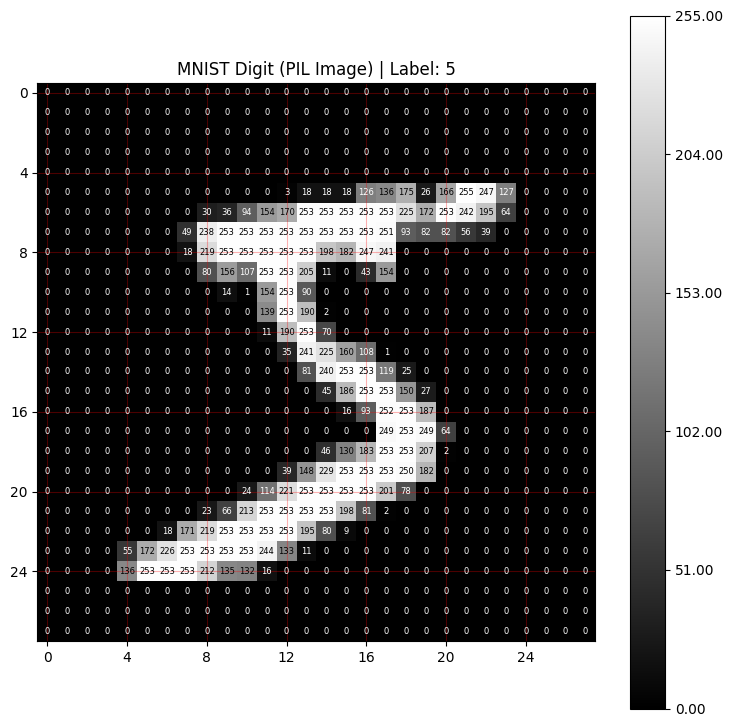

In [13]:
# Visualize the sample image and its corresponding label
helper_utils.display_image(image_pil, label, "MNIST Digit (PIL Image)", show_values=True)

### The Effect of Transformations

You’ve now seen the raw data: a standard **PIL image** with pixel values ranging from 0 to 255. Next, you’ll prepare the data for the model by applying transformations and see how these steps change the image’s structure and numerical values.

#### Transformations

You'll use [transforms.Compose](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html) to chain together a sequence of preparation steps that are applied to each image as it’s loaded. For this task, you’ll use two of the most common transformations:

* <code>[transforms.ToTensor()](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)</code>: Converts the PIL image into a PyTorch tensor and scales its pixel values from the original 0–255 range to values between 0 and 1.
* <code>[transforms.Normalize()](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)</code>: Adjusts the tensor’s values further by centering them around zero, using the mean and standard deviation calculated from the MNIST dataset. This makes the data more consistent and helps the model learn faster and more reliably.

In [14]:
# Convert the images to tensors and normalize pixel values
# Pixel values are scaled to [0, 1] and then standardized to mean 0 and std 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # MNIST mean and std
])

Now you'll load the dataset again, this time applying the transformations you just defined. The code is nearly identical to before, with one important addition.

* The `transform` argument is assigned the `transform` object you created earlier. This tells the `Dataset` to automatically apply your sequence of transformations (`ToTensor` and `Normalize`) to each image as it's loaded.

In [15]:
train_dataset = torchvision.datasets.MNIST(
    root=data_path,     # Path to the directory where the data is/will be stored
    train=True,         # Specify that you want the training split of the dataset
    download=True,      # Download the data if it's not found in the root directory
    transform=transform # Apply the defined transformations to each image
)

Let's access the same item again, this time from the dataset with transformations applied. Notice the key differences in the output.

* The image is no longer a PIL Image because the `ToTensor` transform has converted it into a `torch.Tensor`, the format PyTorch models require.
* The shape is now `(1, 28, 28)`. PyTorch structures image tensors as `[channels, height, width]`. Since the images are grayscale, there is only one channel.

In [16]:
# Access the first item again
image_tensor, label = train_dataset[0]

print(f"Image Type:                   {type(image_tensor)}")
# Since the `image` is now a PyTorch Tensor, its dimensions are accessed using the .shape attribute.
print(f"Image Shape After Transform:  {image_tensor.shape}")
print(f"Label Type:                   {type(label)}")
print(f"Label value:                  {label}")

Image Type:                   <class 'torch.Tensor'>
Image Shape After Transform:  torch.Size([1, 28, 28])
Label Type:                   <class 'int'>
Label value:                  5


#### Visualizing a Transformed Digit

You can now visualize that same digit again, but this time after the transformations have been applied.

* Look closely at the pixel values. They are no longer in the 0-255 range. The Normalize transform has shifted these values so they are now **centered around zero**, giving a new range of approximately **-0.42** to **2.82**.
* The color bar on the right confirms this change. Pixels that were originally dark (low values) now have negative numbers, while bright pixels have large positive values.
    * You can try running the function again with `show_values=False` to view the image without the numerical grid.
    
This normalization process is a key step in preparing data for a neural network. It keeps the input values consistent and helps the model train more effectively.

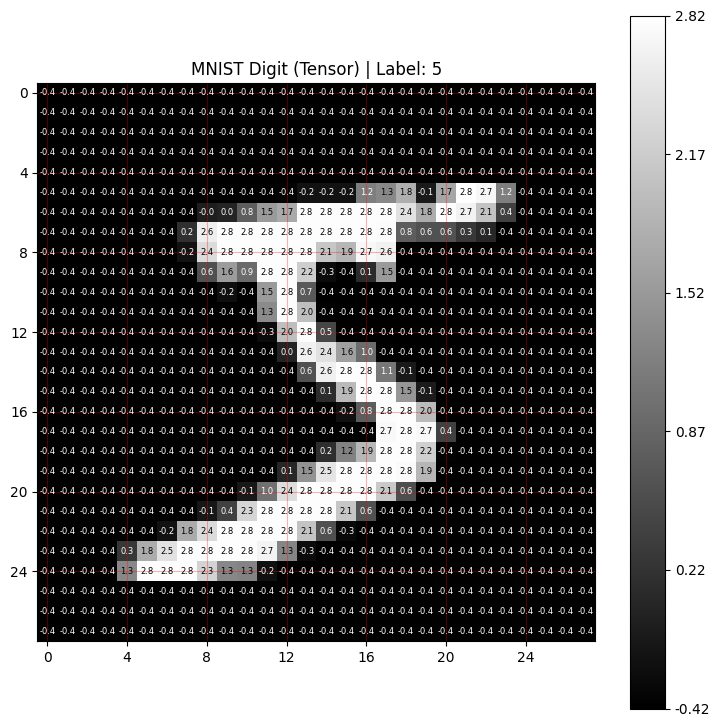

In [17]:
# Visualize the transformed image and its label
helper_utils.display_image(image_tensor, label, "MNIST Digit (Tensor)", show_values=True)

### Completing the Data Pipeline

You’ve seen how transformations prepare your raw images for training. Now it’s time to complete the data pipeline by creating a test dataset and wrapping both datasets with a DataLoader.

#### Load the Test Dataset

In addition to the training data, you need a separate dataset for testing that the model has never seen before. This allows you to evaluate how well the model generalizes to new examples.

* You'll load the test set using the same `torchvision.datasets.MNIST` function as before, but with one key difference: set `train=False` to specify that you want the 10,000 test images.

In [18]:
test_dataset = torchvision.datasets.MNIST(
    root=data_path,     # Path to the directory where the data is/will be stored
    train=False,        # Specify that you want the testing split of the dataset
    download=True,      # Download the data if it's not found in the root directory
    transform=transform # Apply the defined transformations to each image
)

#### Create Data Loaders

The final step in your data pipeline is to create [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders) instances. A `DataLoader` takes your `Dataset` and serves it in manageable chunks called **batches**. This is essential for training on large datasets, as it avoids loading all the data into memory at once.

* **Training Loader**: For the training set, use a `batch_size` of 64 and set `shuffle=True`. Shuffling is critical during training because it randomizes the order of samples in each pass (epoch). This prevents the model from memorizing patterns in the dataset order and helps it generalize better.

* **Test Loader**: For the test set, you can use a much larger batch size (e.g., 1000) since gradients are not calculated during evaluation. This saves memory and speeds up testing. You'll set `shuffle=False` because the order of the data doesn't matter when you're only measuring the model's final performance.

In [19]:
# Create a data loader for the training set with shuffling enabled
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create a data loader for the test set with a larger batch size and no shuffling
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

## Building the Neural Network Model

With your data pipeline complete, it's time to define the neural network's architecture. You'll create a custom model by creating a class that inherits from PyTorch's [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). This pattern is flexible and gives you full control over the model’s structure.

Every `nn.Module` class has two essential parts:

* The `__init__` method is where you define and initialize the layers your model will use, like gathering your tools before starting a job.
* The `forward` method is where you define the exact path the data takes as it flows through those layers.


### Define the Model

Your model's architecture will include the following key components:

* <code>[nn.Flatten()](https://docs.pytorch.org/docs/stable/generated/torch.nn.modules.flatten.Flatten.html)</code>: This layer's job is to transform the 2D image data (28x28 pixels) into a 1D vector of 784 elements (28 * 28 = 784). This reshaping step is required before passing the data into linear layers, which expect flat vectors rather than grids.

* <code>[nn.Linear()](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)</code>: These are the core layers of your network. The first linear layer will map the 784 input pixels to 128 hidden features, and the second will map those 128 features to 10 output classes, one for each digit class (0-9).

* <code>[nn.ReLU()](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)</code>: This is your activation function. It introduces non-linearity, enabling the model to learn complex patterns that simple linear transformations cannot capture.

In [20]:
class SimpleMNISTDNN(nn.Module):
    """
    A simple deep neural network model for the MNIST dataset.

    This model consists of a flatten layer followed by two linear layers
    with a ReLU activation function. It is designed for classification tasks
    on 28x28 grayscale images.
    """
    def __init__(self):
        """
        Initializes the layers of the neural network.
        """
        super(SimpleMNISTDNN, self).__init__()
        # Initializes a layer to flatten the input tensor.
        # 28x28 input image to a 784-dimensional vector.
        self.flatten = nn.Flatten()
        # Initializes the sequential layers of the neural network
        self.layers = nn.Sequential(
            # Defines the first linear layer with 784 input features and 128 output features.
            nn.Linear(784, 128),
            # Applies the rectified linear unit activation function.
            nn.ReLU(),
            # Defines the second linear layer with 128 input features and 10 output features.
            nn.Linear(128, 10)
        )

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x: The input tensor.

        Returns:
            The output tensor after passing through the network layers.
        """
        # Flattens the input tensor.
        x = self.flatten(x)
        # Passes the flattened tensor through the sequential layers.
        x = self.layers(x)
        return x    

## Training the Model

You’ve prepared the data and defined the model architecture. However, at this point the model is untrained, so its predictions will be random guesses.

In this section, you'll bring the model to life by training it on the MNIST data. This involves setting up the necessary tools (a loss function and an optimizer), defining the training and evaluation logic, and running the main training loop.


### Initialize Model, Loss Function, and Optimizer

Before training, set up three essential components:

* **The Model**: First, you'll create an instance of the SimpleMNISTDNN class you defined earlier. 
    * As you saw in the lectures, it is essential for the model and the data to be on the same device to prevent errors. In this notebook, you'll handle this inside the training function itself. By moving both the model and the data to the `device` within that function, you guarantee they are correctly placed right before any computations happen.
>
* **The Loss Function**: You'll use <code>[nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)</code> as your loss function. This is the standard choice for multi-class classification tasks like MNIST because it is specifically designed to measure the error when a model has to choose one class from several possibilities (i.e., one digit from 0-9).

* **The Optimizer**: You'll use <code>[optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)</code>, a popular and highly effective optimizer. The optimizer's job is to update the model's weights to minimize the loss. `Adam` is known for adapting the learning rate as it trains, which often helps the model learn more quickly and reliably than other optimizers.

In [21]:
# Initialize the neural network model
model = SimpleMNISTDNN()

# Define the loss function, suitable for multi-class classification
loss_function = nn.CrossEntropyLoss()

# Set up the Adam optimizer to update the model's parameters with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Define the Training Function

This function encapsulates all the logic for a **single training epoch**, which is one full pass through the dataset. Each iteration over a **single batch** of data within that epoch is called a **step**. As a reminder, this function performs these key operations:

* **Model Preparation**: Before iterating over the data, it prepares the model by moving it to the correct `device` and setting it to training mode with `model.train()`.

* **Core Training Loop**: For each batch of data, it executes the essential five-step training sequence: clearing gradients, running a forward pass, calculating loss, performing backpropagation, and updating the model's weights.

* **Progress Reporting**: Finally, it tracks the running loss and accuracy, printing periodic updates to monitor how well the model is learning.
    * Specifically, with **60,000** training images and a batch size of **64**, the function will report its progress every **134 steps**, giving you **7** consistent updates throughout the epoch.

In [22]:
def train_epoch(model, loss_function, optimizer, train_loader, device):
    """
    Trains a PyTorch model for a single epoch.

    This function iterates over the training dataset, performs the forward and
    backward passes, and updates the model's weights. It also tracks and
    prints the loss and accuracy at specified intervals.

    Args:
        model: The neural network model to be trained.
        loss_function: The loss function used to calculate the error.
        optimizer: The optimizer used to update the model's weights.
        train_loader: The DataLoader providing batches of training data.
        device: The device (e.g., 'cuda' or 'cpu') on which to perform training.

    Returns:
        A tuple containing:
        - model: The model after training for one epoch.
        - avg_epoch_loss: The average loss calculated over all batches in the epoch.
    """
    # Ensure the model is on the correct device for training
    model = model.to(device)
    # Set the model to training mode
    model.train()
    
    # Initialize trackers for the entire epoch's loss
    epoch_loss = 0.0
    
    # Initialize trackers for periodic progress reporting
    running_loss = 0.0
    num_correct_predictions = 0
    total_predictions = 0
    total_batches = len(train_loader)

    # Iterate over the training data in batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move the current batch of data to the specified device
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Clear any gradients from the previous iteration
        optimizer.zero_grad()
        
        # Perform a forward pass to get model predictions
        outputs = model(inputs)
        
        # Calculate the loss for the current batch
        loss = loss_function(outputs, targets)
        
        # Perform backpropagation to compute gradients
        loss.backward()
        
        # Update the model's weights based on the computed gradients
        optimizer.step()
        
        # Accumulate the loss for tracking and reporting
        loss_value = loss.item()
        epoch_loss += loss_value
        running_loss += loss_value
        
        # Calculate accuracy metrics for the current batch
        _, predicted_indices = outputs.max(1)
        batch_size = targets.size(0)
        total_predictions += batch_size
        num_correct_in_batch = predicted_indices.eq(targets).sum().item()
        num_correct_predictions += num_correct_in_batch

        # Check if it's time to print a progress update
        if (batch_idx + 1) % 134 == 0 or (batch_idx + 1) == total_batches:
            # Calculate average loss and accuracy for the current interval
            avg_running_loss = running_loss / 134
            accuracy = 100. * num_correct_predictions / total_predictions
            
            # Print the progress update
            print(f'\tStep {batch_idx + 1}/{total_batches} - Loss: {avg_running_loss:.3f} | Acc: {accuracy:.2f}%')
            
            # Reset the trackers for the next reporting interval
            running_loss = 0.0
            num_correct_predictions = 0
            total_predictions = 0
            
    # Calculate the average loss for the entire epoch
    avg_epoch_loss = epoch_loss / total_batches
    # Return the trained model and the average epoch loss
    return model, avg_epoch_loss

### Define the Evaluation Function

After training your model, you need a way to measure its performance on data it has never seen before. While the training process shows how well the model is learning the training data, `evaluate` reveals whether it can generalize that learning to new examples. It's similar to the training loop but optimized for inference, with a few key differences:

* **Setup for Inference**: The model is set to evaluation mode with `model.eval()` and gradient calculations are disabled using a `torch.no_grad()` block. These steps are essential for correct results and make the process faster and more memory-efficient.

* **Simplified Forward Pass**: The loop is much simpler than in training. It only performs a forward pass to get the model's predictions and calculate accuracy. There are no loss calculations, backpropagation, or weight updates with an optimizer.

In [23]:
def evaluate(model, test_loader, device):
    """
    Evaluates the model's accuracy on a test dataset.

    This function sets the model to evaluation mode, iterates through the test data,
    and calculates the percentage of correct predictions.

    Args:
        model: The neural network model to be evaluated.
        test_loader: A data loader containing the test dataset.
        device: The device (e.g., 'cpu' or 'cuda') to run the evaluation on.

    Returns:
        The accuracy of the model on the test dataset as a percentage.
    """
    # Sets the model to evaluation mode.
    model.eval()
    # Initializes a counter for correct predictions.
    num_correct_predictions = 0
    # Initializes a counter for the total number of predictions.
    total_predictions = 0

    # Disables gradient calculation to reduce memory usage and speed up computations.
    with torch.no_grad():
        # Iterates over all batches in the test data loader.
        for inputs, targets in test_loader:
            # Moves the input data and targets to the specified device.
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Performs a forward pass to get the model's output.
            outputs = model(inputs)
            
            # Retrieves the index of the highest value in the output tensor, which represents the predicted class.
            _, predicted_indices = outputs.max(1)
            
            # Gets the size of the current batch.
            batch_size = targets.size(0)
            # Adds the batch size to the total number of predictions.
            total_predictions = total_predictions + batch_size
            
            # Compares the predicted indices with the actual target values.
            correct_predictions = predicted_indices.eq(targets)
            # Sums the correct predictions in the current batch.
            num_correct_in_batch = correct_predictions.sum().item()
            # Adds the correct predictions from the current batch to the total count.
            num_correct_predictions = num_correct_predictions + num_correct_in_batch

    # Calculates the overall accuracy as a percentage.
    accuracy_percentage = (num_correct_predictions / total_predictions) * 100
    # Prints the calculated accuracy to the console.
    print((f'\tAccuracy - {accuracy_percentage:.2f}%'))
    
    return accuracy_percentage

### The Training Loop

This is where all the components you’ve built come together to train the model. The loop runs for a set number of epochs, where each epoch represents one complete pass through the entire dataset. Training for multiple epochs lets the model see the data repeatedly, gradually adjusting its internal weights to improve accuracy.

The logic inside each epoch is straightforward and follows a standard pattern:

* First, you call the `train_epoch` function to train the model on all the training data.

* Immediately after, you call the `evaluate` function to measure the model's performance on the unseen test data. This is a vital step to check if the model is actually learning to **generalize** or if it's just memorizing the training set.

Finally, the loss and accuracy from each epoch are stored in lists so you can analyze the model's progress over time.

In [24]:
# Set the total number of training epochs (Feel free to set a different number)
num_epochs = 5

# Initialize lists to store metrics from each epoch for later analysis
train_loss = []
test_acc = []

# Begin the training and evaluation process
for epoch in range(num_epochs):
    print(f'\n[Training] Epoch {epoch+1}:')
    # Call the training function to train the model for one epoch
    trained_model, loss = train_epoch(model, loss_function, optimizer, train_loader, device)
    # Store the average training loss for the epoch
    train_loss.append(loss)
    
    print(f'[Testing] Epoch {epoch+1}:')
    # Call the evaluation function to measure performance on the test set
    accuracy = evaluate(trained_model, test_loader, device)
    # Store the test accuracy for the epoch
    test_acc.append(accuracy)


[Training] Epoch 1:
	Step 134/938 - Loss: 0.560 | Acc: 83.99%
	Step 268/938 - Loss: 0.302 | Acc: 91.16%
	Step 402/938 - Loss: 0.250 | Acc: 92.78%
	Step 536/938 - Loss: 0.203 | Acc: 93.76%
	Step 670/938 - Loss: 0.171 | Acc: 94.97%
	Step 804/938 - Loss: 0.173 | Acc: 95.00%
	Step 938/938 - Loss: 0.150 | Acc: 95.55%
[Testing] Epoch 1:
	Accuracy - 95.83%

[Training] Epoch 2:
	Step 134/938 - Loss: 0.128 | Acc: 96.22%
	Step 268/938 - Loss: 0.123 | Acc: 96.21%
	Step 402/938 - Loss: 0.124 | Acc: 96.32%
	Step 536/938 - Loss: 0.107 | Acc: 96.67%
	Step 670/938 - Loss: 0.113 | Acc: 96.57%
	Step 804/938 - Loss: 0.107 | Acc: 96.83%
	Step 938/938 - Loss: 0.092 | Acc: 97.43%
[Testing] Epoch 2:
	Accuracy - 97.11%

[Training] Epoch 3:
	Step 134/938 - Loss: 0.079 | Acc: 97.74%
	Step 268/938 - Loss: 0.082 | Acc: 97.54%
	Step 402/938 - Loss: 0.071 | Acc: 97.85%
	Step 536/938 - Loss: 0.080 | Acc: 97.66%
	Step 670/938 - Loss: 0.083 | Acc: 97.39%
	Step 804/938 - Loss: 0.071 | Acc: 97.88%
	Step 938/938 - Loss:

## Analyzing Model Performance

With the training complete, the final step is to analyze your model's performance. You'll do this in two ways: **qualitatively**, by looking at some of its specific predictions, and **quantitatively**, by plotting its performance metrics over time.

### Visualizing Predictions

Now that the model is trained, let's see it in action. A great way to get a feel for its performance is to visualize the predictions it makes on random samples from the test set. This allows you to see concrete examples of where the model succeeds and where it might be making mistakes.

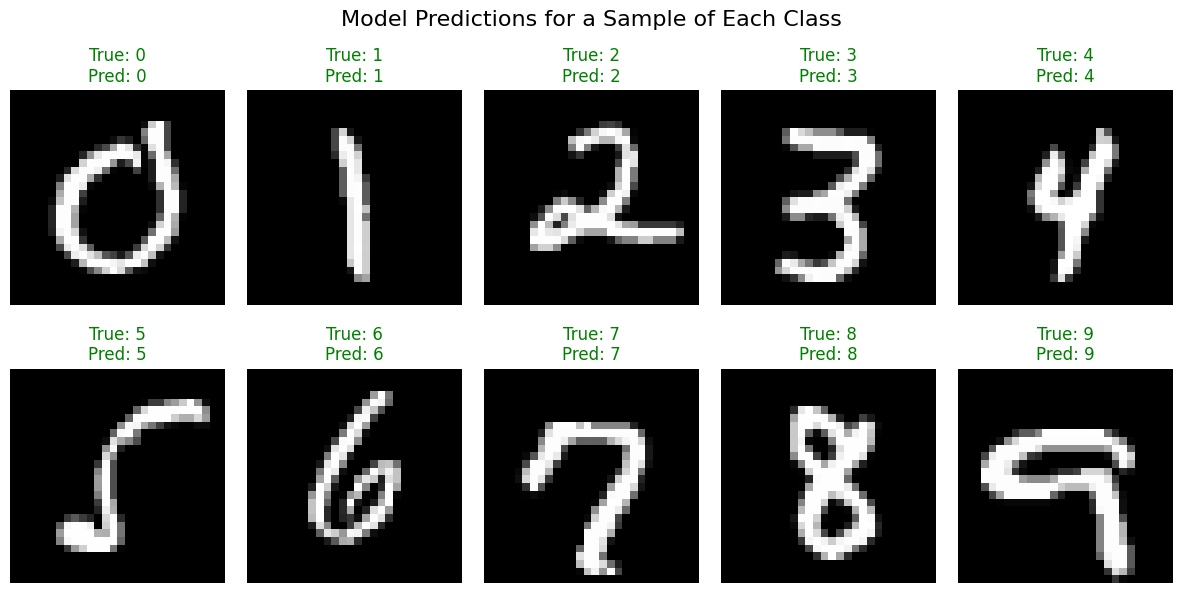

In [25]:
# Visualize model predictions on a random sample of test images
helper_utils.display_predictions(trained_model, test_loader, device)

### Plotting Performance Metrics

Looking at individual predictions can be helpful, but visualizing overall performance gives you a clearer view of how training progressed. Plotting the training loss and test accuracy across epochs helps you evaluate how effectively the model learned.

* **Training Loss**: This plot should show a steady downward trend, indicating that the model is learning from the training data and reducing its error over time.

* **Test Accuracy**: This plot should show an upward trend as the model improves its ability to generalize to new, unseen data. A rising test accuracy indicates that the model isn’t just memorizing the training set, but is actually learning patterns that transfer to new examples. When the curve begins to flatten, it often means the model has learned as much as it can from the current setup.

# Conclusion

Congratulations on completing the lab! You have successfully navigated the entire machine learning pipeline to build, train, and analyze your very own image classifier.

You started with raw image data and saw firsthand why **data preparation**, transforming and normalizing your inputs, is such a fundamental first step. You then built a custom neural network architecture, gaining practice with the power and flexibility of **`nn.Module`**.

Most importantly, you implemented the **core training loop**, the engine that drives the learning process, and used a separate **evaluation function** to get an honest measure of your model's ability to generalize to new, unseen data. The final plots of loss and accuracy provided a clear, quantitative story of your model's journey from random guessing to accurate recognition.

The skills you’ve practiced here form the foundation for tackling more advanced deep learning challenges ahead. Well done!